In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    #rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    rf = RandomForestRegressor(n_estimators=10, criterion='squared_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features='sqrt')
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.001)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1E-4, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

In [4]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [5]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_a', 'Coef_c', 'Coef_d'], axis=1, inplace = True)
target = 'Coef_b'

In [6]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [7]:
data_std=d.copy()
scalerSTD=StandardScaler()
scalerSTD.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scalerSTD.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [8]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


In [9]:
#data_std.to_csv("scaled_non_correlated.csv")

### Using CV technique

RF
R2:  0.8969923711609126
RMSE:  0.3209480157892979
---------------------------------------
GB
R2:  0.8503179513964589
RMSE:  0.3868876433844083
---------------------------------------
RR
R2:  -1.443280683559189
RMSE:  1.5630997036527097
---------------------------------------
LASSO
R2:  0.492679984953869
RMSE:  0.7122640065636694
---------------------------------------
gpr1
R2:  0.3850465005250726
RMSE:  0.7841897088555341
---------------------------------------
gpr2
R2:  0.9235144870644686
RMSE:  0.2765601434327286
---------------------------------------
gpr3
R2:  0.9261440833122672
RMSE:  0.2717644507431625
---------------------------------------
gpr4
R2:  0.9156622348255488
RMSE:  0.29040965062210183
---------------------------------------
[0.8969923711609126, 0.8503179513964589, -1.443280683559189, 0.492679984953869, 0.3850465005250726, 0.9235144870644686, 0.9261440833122672, 0.9156622348255488]


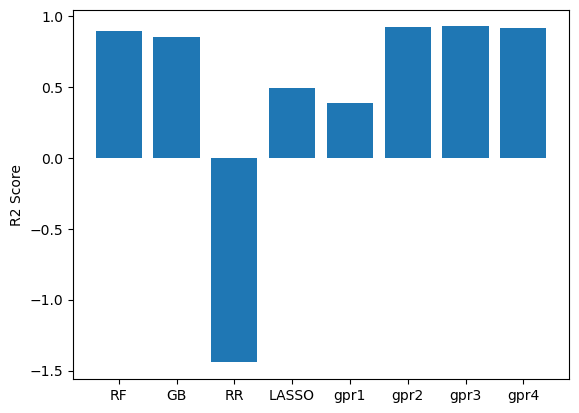

In [10]:
run_models()

## Feature selection


In [11]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  126.044006
28      X_EA  103.886132
35      X_Ra   93.260694
2        s_X   92.541192
17       X_Z   91.454183
7   mean_X2X   75.264201
1        s_B   59.910760
33    A_Rvdw   57.675309
0        s_A   51.729561
5   mean_A2X   51.569746
20     A_IEI   38.391765
12     E_coh   33.972057
25    X_IEII   24.989071
31    A_ChiA   20.970549
42      B_Hf   20.432377
9    std_A2X   17.648197
29    A_ChiP   16.845472
36      B_MP   16.262954
10   std_B2X   13.967425
37      A_BP   13.449987
34      B_Ra   13.090297
26      A_EA   12.418282
14        OF   12.249707
15       A_Z   12.150767
45   X_Kappa   10.287385
16       B_Z    9.949890
46     A_CvM    8.675611
43   A_Kappa    8.297802
44   B_Kappa    6.966805
40      B_MV    6.707130


In [12]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'A_BP', 'B_Ra',
       'A_EA', 'OF', 'A_Z', 'X_Kappa', 'B_Z', 'A_CvM', 'A_Kappa',
       'B_Kappa', 'B_MV', 'std_A2B', 'X_MV', 'A_B', 'X_ChiA', 'A_G',
       'B_CvM', 'X_IEI', 'B_Rho', 'std_X2X', 'B_EA'], dtype=object)

In [13]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8538563763889978
RMSE:  0.3822873573779313
---------------------------------------
GB
R2:  0.8593393839287407
RMSE:  0.37504748508856756
---------------------------------------
RR
R2:  0.1152455792471001
RMSE:  0.9406138531580851
---------------------------------------
LASSO
R2:  0.6692161696442388
RMSE:  0.5751380967696029
---------------------------------------
gpr1
R2:  0.7422456552367575
RMSE:  0.5076951297415039
---------------------------------------
gpr2
R2:  0.9244976578096629
RMSE:  0.27477689529932675
---------------------------------------
gpr3
R2:  0.9256142786290286
RMSE:  0.27273745868686866
---------------------------------------
gpr4
R2:  0.9210887067243672
RMSE:  0.2809115399474234
---------------------------------------
[0.8538563763889978, 0.8593393839287407, 0.1152455792471001, 0.6692161696442388, 0.7422456552367575, 0.9244976578096629, 0.9256142786290286, 0.9210887067243672]


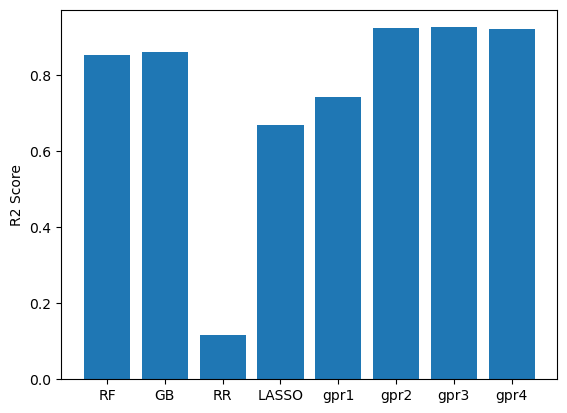

In [14]:
run_models()

In [15]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'A_BP', 'B_Ra',
       'A_EA', 'OF', 'A_Z', 'X_Kappa', 'B_Z', 'A_CvM', 'A_Kappa',
       'B_Kappa', 'B_MV'], dtype=object)

In [16]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
t30_columns = ['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA']
data_save=data_std[t30_columns]
#data_save.to_csv("scaled_top_30.csv")

RF
R2:  0.8719408703715856
RMSE:  0.35785350302660773
---------------------------------------
GB
R2:  0.8599609344945267
RMSE:  0.3742179385137399
---------------------------------------
RR
R2:  0.6815009385955753
RMSE:  0.5643572108199069
---------------------------------------
LASSO
R2:  0.7150973759344612
RMSE:  0.5337627038914753
---------------------------------------
gpr1
R2:  0.6965274448031489
RMSE:  0.5508834315868022
---------------------------------------
gpr2
R2:  0.9270642231342464
RMSE:  0.2700662453283519
---------------------------------------
gpr3
R2:  0.9285326152821806
RMSE:  0.2673338450660884
---------------------------------------
gpr4
R2:  0.9251483956291187
RMSE:  0.2735902124910198
---------------------------------------
[0.8719408703715856, 0.8599609344945267, 0.6815009385955753, 0.7150973759344612, 0.6965274448031489, 0.9270642231342464, 0.9285326152821806, 0.9251483956291187]


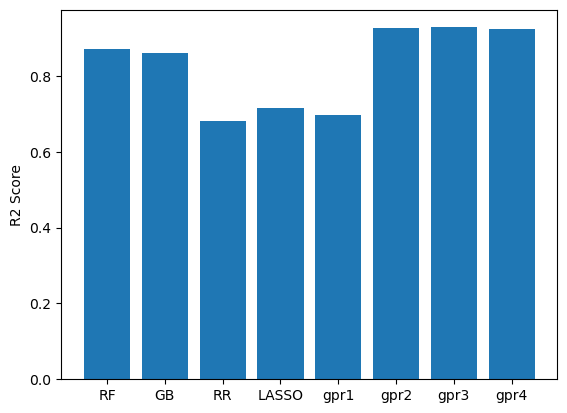

In [17]:
run_models()

In [18]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'A_BP'],
      dtype=object)

In [19]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8799295925787292
RMSE:  0.3465117709707289
---------------------------------------
GB
R2:  0.8346685588808415
RMSE:  0.40660969137387576
---------------------------------------
RR
R2:  0.8052568065795193
RMSE:  0.4412971713261719
---------------------------------------
LASSO
R2:  0.8192526732952845
RMSE:  0.4251438894124147
---------------------------------------
gpr1
R2:  0.8359875763498987
RMSE:  0.40498447334447424
---------------------------------------
gpr2
R2:  0.9198109116171508
RMSE:  0.2831767793849792
---------------------------------------
gpr3
R2:  0.9243886506036063
RMSE:  0.2749751796006208
---------------------------------------
gpr4
R2:  0.9299481516990824
RMSE:  0.264673097047882
---------------------------------------
[0.8799295925787292, 0.8346685588808415, 0.8052568065795193, 0.8192526732952845, 0.8359875763498987, 0.9198109116171508, 0.9243886506036063, 0.9299481516990824]


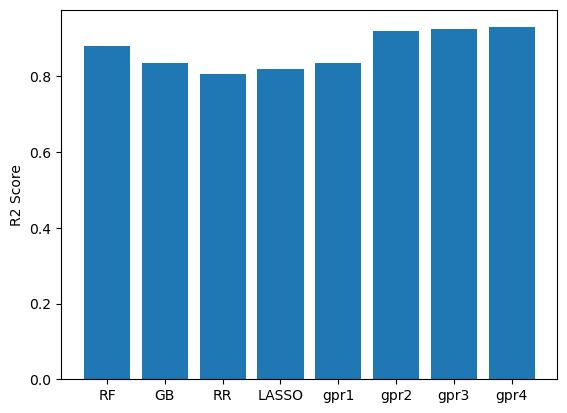

In [20]:
run_models()

In [21]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X'], dtype=object)

In [22]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9036882281848144
RMSE:  0.31034137947619156
---------------------------------------
GB
R2:  0.8463357306709246
RMSE:  0.39200034353183333
---------------------------------------
RR
R2:  0.8435191630076839
RMSE:  0.39557658802350276
---------------------------------------
LASSO
R2:  0.8447463182623667
RMSE:  0.39402243811442167
---------------------------------------
gpr1
R2:  0.8569572882628025
RMSE:  0.37820987789479726
---------------------------------------
gpr2
R2:  0.9092576737500354
RMSE:  0.30123466973435276
---------------------------------------
gpr3
R2:  0.9022128482223557
RMSE:  0.3127093727051435
---------------------------------------
gpr4
R2:  0.8952401272137609
RMSE:  0.32366629850239137
---------------------------------------
[0.9036882281848144, 0.8463357306709246, 0.8435191630076839, 0.8447463182623667, 0.8569572882628025, 0.9092576737500354, 0.9022128482223557, 0.8952401272137609]


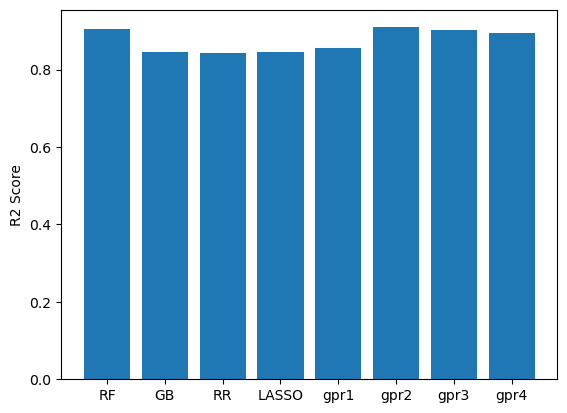

In [23]:
run_models()

# Min-Max scaling

In [24]:
data_std=d.copy()
scalerMM=MinMaxScaler()
scalerMM.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scalerMM.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [25]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)
#data_std.to_csv('Coef_a_scaled_non_corr_all.csv',index=False)

(80, 51)


### Using CV technique

RF
R2:  0.8731378916837786
RMSE:  0.09512222873816505
---------------------------------------
GB
R2:  0.835638859523656
RMSE:  0.10827186760651132
---------------------------------------
RR
R2:  0.6706632552368235
RMSE:  0.1532625860587924
---------------------------------------
LASSO
R2:  0.8615632459608664
RMSE:  0.09936690406808608
---------------------------------------
gpr1
R2:  0.8333048812987818
RMSE:  0.10903790444241442
---------------------------------------
gpr2
R2:  0.9270169600603049
RMSE:  0.07214845400964763
---------------------------------------
gpr3
R2:  0.9216986268166927
RMSE:  0.07473099148474933
---------------------------------------
gpr4
R2:  0.8922983069046606
RMSE:  0.08764503530732067
---------------------------------------
[0.8731378916837786, 0.835638859523656, 0.6706632552368235, 0.8615632459608664, 0.8333048812987818, 0.9270169600603049, 0.9216986268166927, 0.8922983069046606]


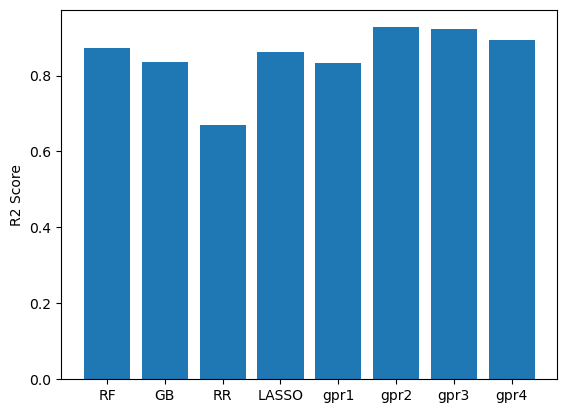

In [26]:
run_models()

## Feature selection


In [27]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  126.044006
28      X_EA  103.886132
35      X_Ra   93.260694
2        s_X   92.541192
17       X_Z   91.454183
7   mean_X2X   75.264201
1        s_B   59.910760
33    A_Rvdw   57.675309
0        s_A   51.729561
5   mean_A2X   51.569746
20     A_IEI   38.391765
12     E_coh   33.972057
25    X_IEII   24.989071
31    A_ChiA   20.970549
42      B_Hf   20.432377
9    std_A2X   17.648197
29    A_ChiP   16.845472
36      B_MP   16.262954
10   std_B2X   13.967425
37      A_BP   13.449987
34      B_Ra   13.090297
26      A_EA   12.418282
14        OF   12.249707
15       A_Z   12.150767
45   X_Kappa   10.287385
16       B_Z    9.949890
46     A_CvM    8.675611
43   A_Kappa    8.297802
44   B_Kappa    6.966805
40      B_MV    6.707130


In [28]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'A_BP', 'B_Ra',
       'A_EA', 'OF', 'A_Z', 'X_Kappa', 'B_Z', 'A_CvM', 'A_Kappa',
       'B_Kappa', 'B_MV', 'std_A2B', 'X_MV', 'A_B', 'X_ChiA', 'A_G',
       'B_CvM', 'X_IEI', 'B_Rho', 'std_X2X', 'B_EA'], dtype=object)

In [29]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9021961322485904
RMSE:  0.08352068929646449
---------------------------------------
GB
R2:  0.8506963421552096
RMSE:  0.10319324725865468
---------------------------------------
RR
R2:  0.7046704755898943
RMSE:  0.1451341079904167
---------------------------------------
LASSO
R2:  0.8704201425065886
RMSE:  0.09613572459807349
---------------------------------------
gpr1
R2:  0.860590010298429
RMSE:  0.09971557607545238
---------------------------------------
gpr2
R2:  0.9276135735724407
RMSE:  0.07185295334736395
---------------------------------------
gpr3
R2:  0.9240971229594589
RMSE:  0.07357752482975168
---------------------------------------
gpr4
R2:  0.8940311293760046
RMSE:  0.08693711177183079
---------------------------------------
[0.9021961322485904, 0.8506963421552096, 0.7046704755898943, 0.8704201425065886, 0.860590010298429, 0.9276135735724407, 0.9240971229594589, 0.8940311293760046]


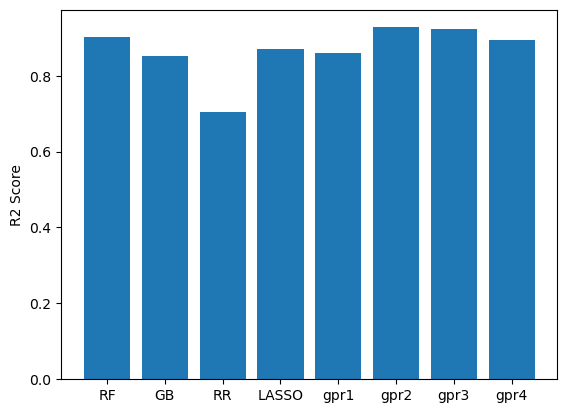

In [30]:
run_models()

In [31]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'A_BP', 'B_Ra',
       'A_EA', 'OF', 'A_Z', 'X_Kappa', 'B_Z', 'A_CvM', 'A_Kappa',
       'B_Kappa', 'B_MV'], dtype=object)

In [32]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8981513454926746
RMSE:  0.08523023836767499
---------------------------------------
GB
R2:  0.8264708173350439
RMSE:  0.11125058815087654
---------------------------------------
RR
R2:  0.6939132334966305
RMSE:  0.1477536886524527
---------------------------------------
LASSO
R2:  0.8764892836297367
RMSE:  0.0938573688746374
---------------------------------------
gpr1
R2:  0.8290572883461171
RMSE:  0.1104183744978367
---------------------------------------
gpr2
R2:  0.9249401641465719
RMSE:  0.07316777696687458
---------------------------------------
gpr3
R2:  0.9221115111720196
RMSE:  0.07453370222503766
---------------------------------------
gpr4
R2:  0.8960406961313547
RMSE:  0.08610883953397402
---------------------------------------
[0.8981513454926746, 0.8264708173350439, 0.6939132334966305, 0.8764892836297367, 0.8290572883461171, 0.9249401641465719, 0.9221115111720196, 0.8960406961313547]


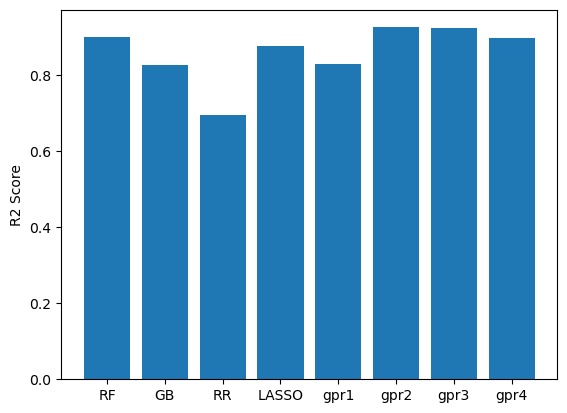

In [33]:
run_models()

In [34]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'A_BP'],
      dtype=object)

In [35]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8953401549885627
RMSE:  0.08639847932883876
---------------------------------------
GB
R2:  0.8264403526433481
RMSE:  0.11126035326956668
---------------------------------------
RR
R2:  0.8244379401045407
RMSE:  0.11190033558428647
---------------------------------------
LASSO
R2:  0.879768843552514
RMSE:  0.09260289568365208
---------------------------------------
gpr1
R2:  0.8584211951164583
RMSE:  0.10048822523320049
---------------------------------------
gpr2
R2:  0.919577445639925
RMSE:  0.07573645731734104
---------------------------------------
gpr3
R2:  0.9272913840150453
RMSE:  0.07201268334977987
---------------------------------------
gpr4
R2:  0.9020785358155594
RMSE:  0.08357088559649342
---------------------------------------
[0.8953401549885627, 0.8264403526433481, 0.8244379401045407, 0.879768843552514, 0.8584211951164583, 0.919577445639925, 0.9272913840150453, 0.9020785358155594]


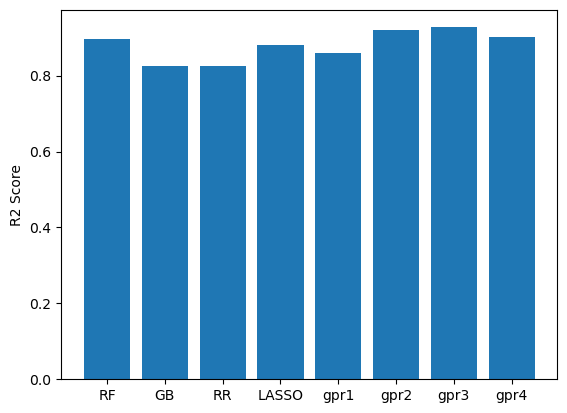

In [36]:
run_models()

In [37]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 's_A', 'mean_A2X'], dtype=object)

In [38]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8774327079831397
RMSE:  0.09349822163206536
---------------------------------------
GB
R2:  0.8478222422501094
RMSE:  0.10418174931832878
---------------------------------------
RR
R2:  0.8461704165342274
RMSE:  0.10474564781828467
---------------------------------------
LASSO
R2:  0.8479391818550295
RMSE:  0.10414171286964378
---------------------------------------
gpr1
R2:  0.8560087691603352
RMSE:  0.10134074136572363
---------------------------------------
gpr2
R2:  0.9068761424346213
RMSE:  0.08149792173164258
---------------------------------------
gpr3
R2:  0.9084117906051834
RMSE:  0.08082316239572022
---------------------------------------
gpr4
R2:  0.8964440842888307
RMSE:  0.0859416152175124
---------------------------------------
[0.8774327079831397, 0.8478222422501094, 0.8461704165342274, 0.8479391818550295, 0.8560087691603352, 0.9068761424346213, 0.9084117906051834, 0.8964440842888307]


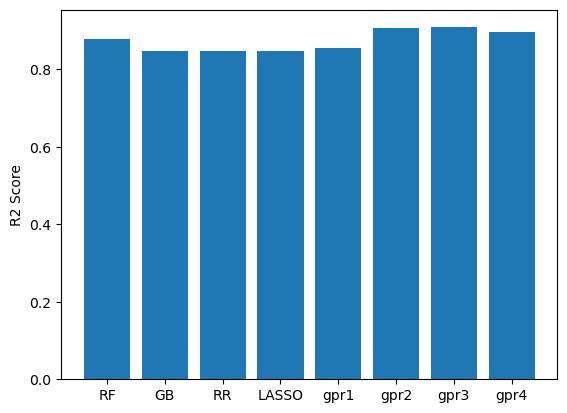

In [39]:
run_models()